In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import cv2
sys.path.insert(0, '../codes')
import video_utils
from skimage.measure import compare_ssim as ssim

/home/wesley.passos/miniconda3/envs/mosquitoes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [3]:
#make matplotlib figures appear inline in the notebook
#rather than in a new window.
%matplotlib inline
#sns.set()
# set default size of plots
plt.rcParams['figure.figsize'] = (12.0, 10.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#print OpenCV version
print ("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.3.1 


In [4]:
def mse(x, y):
    return np.linalg.norm(x - y)/(x.shape[0]*x.shape[1])

## Detecting keypoints and computing cam params

In [5]:
videos_path = '../data/DJI4_cam/2018-08-24/'
video_name = 'DJI_0001.MOV'
video = os.path.join(videos_path, video_name)

In [6]:
vid = video_utils.videoObj(videopath=video)
ret, mtx, dist, rvecs, tvecs = vid.cam_params(frame_step=20)

Calibrating video: DJI_0001.MOV ...


HBox(children=(IntProgress(value=0, max=41), HTML(value='')))

 Searching for chessboard in frame 1...
pattern found
 Searching for chessboard in frame 21...
pattern found
 Searching for chessboard in frame 41...
pattern found
 Searching for chessboard in frame 61...
pattern found
 Searching for chessboard in frame 81...
pattern found
 Searching for chessboard in frame 101...
pattern NOT found
 Searching for chessboard in frame 121...
pattern NOT found
 Searching for chessboard in frame 141...
pattern found
 Searching for chessboard in frame 161...
pattern found
 Searching for chessboard in frame 181...
pattern found
 Searching for chessboard in frame 201...
pattern found
 Searching for chessboard in frame 221...
pattern found
 Searching for chessboard in frame 241...
pattern NOT found
 Searching for chessboard in frame 261...
pattern NOT found
 Searching for chessboard in frame 281...
pattern NOT found
 Searching for chessboard in frame 301...
pattern NOT found
 Searching for chessboard in frame 321...
pattern found
 Searching for chessboard in f

In [7]:
print('rms: {}'.format(ret))
print('camera matrix: \n', mtx)
print('distortion coefficients: ', dist)

rms: 1.276813446818624
camera matrix: 
 [[2.64717632e+03 0.00000000e+00 1.96155624e+03]
 [0.00000000e+00 2.64198114e+03 1.07038852e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [[-0.01462875 -0.09757464 -0.00104951  0.00212136  0.16509278]]


## Testing calibration

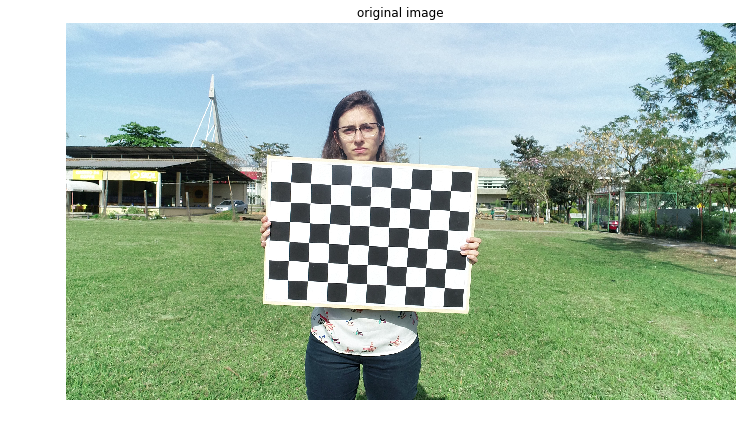

image size:  (2160, 3840, 3)


In [8]:
#load video
video_test = os.path.join(videos_path,video_name)
video_capture = cv2.VideoCapture(video_test)

#extract first frame
success,img = video_capture.read()
h, w = img.shape[:2]

#displaying image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('original image')
plt.show()
print('image size: ', img.shape)

* optimizing camera params:

In [9]:
#optimize camera matrix
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

print('\nCamera matrix: \n', mtx)
print('\nNew camera matrix: \n', newcameramtx)
print('\nRoI: \n', roi)


Camera matrix: 
 [[2.64717632e+03 0.00000000e+00 1.96155624e+03]
 [0.00000000e+00 2.64198114e+03 1.07038852e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

New camera matrix: 
 [[2.61934082e+03 0.00000000e+00 1.96933065e+03]
 [0.00000000e+00 2.60614062e+03 1.06810988e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

RoI: 
 (20, 14, 3805, 2133)


* undistorting frame:

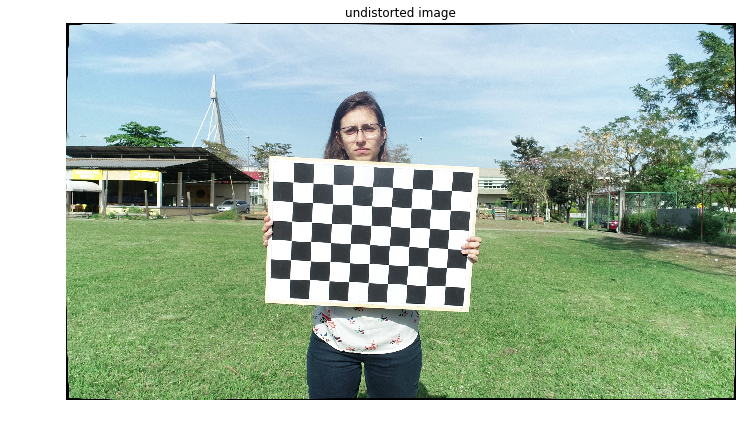

In [10]:
#undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('undistorted image')
plt.show()
# print('image size: ', dst.shape)

* computing SSIM and MSE between images...

In [11]:
mse = mse(img, dst)
ssim = ssim(img, dst, multichannel=True)

print('MSE: ', mse)
print('SSIM: ', ssim)

MSE:  0.09822589710024514
SSIM:  0.5504854791253919


* blending original and undistorted images...

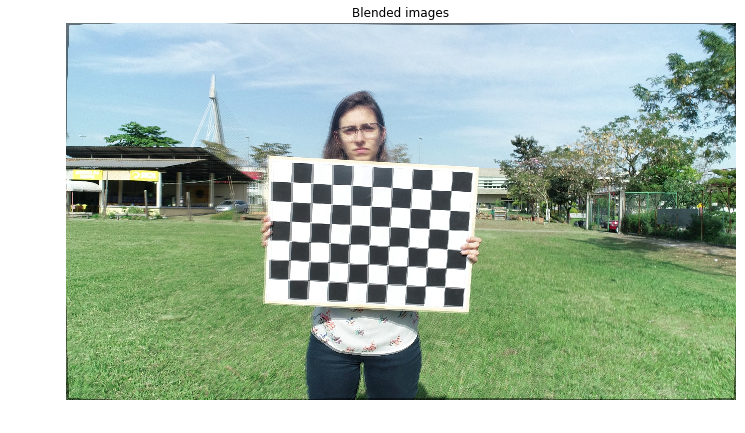

In [12]:
alpha = 0.5
beta = (1.0 - alpha)
blend = np.uint8(alpha*(img)+beta*(dst))

plt.imshow(cv2.cvtColor(blend,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Blended images')
plt.show()